In [3]:
! pip install ./kfac_pytorch

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Processing ./kfac_pytorch
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for kfac-pytorch: filename=kfac_pytorch-0.4.1-py2.py3-none-any.whl size=46268 sha256=8c26d587dfe72bbae9849a3e76af1a7584ff83e796774ca7fc91443c1450b45b
  Stored in directory: /tmp/pip-ephem-wheel-cache-sd3xddjo/wheels/02/e3/8d/9cea3dc920ea6134a9a6010384a614c48802250e8ad04710e0
Successfully built kfac-pytorch


In [2]:
! pip install torch_optimizer

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 61 kB 16.9 MB/s eta 0:00:01


In [1]:
!pip install lion-pytorch

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [4]:
import random
from collections import Counter, defaultdict, namedtuple
from typing import Tuple, List, Dict, Any

import torch
import numpy as np

from tqdm import tqdm, trange
from sam.sam import SAM
from kfac.preconditioner import KFACPreconditioner
import time as times
import pickle
from itertools import product
import torch_optimizer as optim
from lion_pytorch import Lion

In [5]:
def set_global_seed(seed: int) -> None:
    """
    Set global seed for reproducibility.
    """

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


set_global_seed(42)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
!git clone https://github.com/dayyass/msu_task_3_ner.git

fatal: destination path 'msu_task_3_ner' already exists and is not an empty directory.


In [7]:
import pandas as pd
import csv


def read_conll2003(
    path: str,
    lower: bool = True,
) -> Tuple[List[List[str]], List[List[str]]]:
    """
    Prepare data in CoNNL like format.
    """

    token_seq = []
    label_seq = []
    
    # YOUR CODE HERE

    with open(path) as f:
        token_acc = []
        label_acc = []
        for line in f:
            if len(line.split('\t')) < 2:
                token_seq.append(token_acc)
                label_seq.append(label_acc)
                token_acc = []
                label_acc = []
                continue
            t, l = line[:-1].split('\t')
            if lower:
                t = t.lower()
            token_acc.append(t)
            label_acc.append(l) 
    if len(token_acc) != 0:
        token_seq.append(token_acc)
        label_seq.append(label_acc)

    return token_seq, label_seq


train_token_seq, train_label_seq = read_conll2003("msu_task_3_ner/train.tsv")
valid_token_seq, valid_label_seq = read_conll2003("msu_task_3_ner/valid.tsv")
test_token_seq, test_label_seq = read_conll2003("msu_task_3_ner/test.tsv")

In [8]:
token2cnt = Counter([token for sentence in train_token_seq for token in sentence])

def get_token2idx(
    token2cnt: Dict[str, int],
    min_count: int,
) -> Dict[str, int]:
    """
    Get mapping from tokens to indices to use with Embedding layer.
    """

    token2idx: Dict[str, int] = {'<PAD>' : 0, '<UNK>' : 1}
    i = 2
    for token, cnt in token2cnt.items():
        if cnt >= min_count:
            token2idx[token] = i
            i += 1

    return token2idx

token2idx = get_token2idx(token2cnt, min_count=2)

def sort_labels_func(x: str) -> int:
    if x == "O":
        return 0
    elif x.startswith("B-"):
        return 1
    else:
        return 2

label_set = sorted(
    set(label for sentence in train_label_seq for label in sentence),
    key=lambda x: (sort_labels_func(x), x),
)

def get_label2idx(label_set: List[str]) -> Dict[str, int]:
    """
    Get mapping from labels to indices.
    """

    label2idx: Dict[str, int] = {label : i for i, label in enumerate(label_set)}

    return label2idx

label2idx = get_label2idx(label_set)

In [9]:
class NERDataset(torch.utils.data.Dataset):
    """
    PyTorch Dataset for NER.
    """

    def __init__(
        self,
        token_seq: List[List[str]],
        label_seq: List[List[str]],
        token2idx: Dict[str, int],
        label2idx: Dict[str, int],
    ):
        self.token2idx = token2idx
        self.label2idx = label2idx

        self.token_seq = [self.process_tokens(tokens, token2idx) for tokens in token_seq]
        self.label_seq = [self.process_labels(labels, label2idx) for labels in label_seq]

    def __len__(self):
        return len(self.token_seq)

    def __getitem__(
        self,
        idx: int,
    ) -> Tuple[torch.LongTensor, torch.LongTensor]:
        # YOUR CODE HERE
        return torch.LongTensor(self.token_seq[idx]), torch.LongTensor(self.label_seq[idx])
    
    @staticmethod
    def process_tokens(
        tokens: List[str],
        token2idx: Dict[str, int],
        unk: str = "<UNK>",
    ) -> List[int]:
        """
        Transform list of tokens into list of tokens' indices.
        """
        # YOUR CODE HERE
        token_index = []
        for token in tokens:
            if token in token2idx:
                token_index.append(token2idx[token])
            else:
                token_index.append(token2idx[unk])
        return token_index

    @staticmethod
    def process_labels(
        labels: List[str],
        label2idx: Dict[str, int],
    ) -> List[int]:
        """
        Transform list of labels into list of labels' indices.
        """
        # YOUR CODE HERE
        label_index = []
        for label in labels:
            label_index.append(label2idx[label])

        return label_index
    
train_dataset = NERDataset(
    token_seq=train_token_seq,
    label_seq=train_label_seq,
    token2idx=token2idx,
    label2idx=label2idx,
)
valid_dataset = NERDataset(
    token_seq=valid_token_seq,
    label_seq=valid_label_seq,
    token2idx=token2idx,
    label2idx=label2idx,
)
test_dataset = NERDataset(
    token_seq=test_token_seq,
    label_seq=test_label_seq,
    token2idx=token2idx,
    label2idx=label2idx,
)

In [10]:
class NERCollator:
    """
    Collator that handles variable-size sentences.
    """

    def __init__(
        self,
        token_padding_value: int,
        label_padding_value: int,
    ):
        self.token_padding_value = token_padding_value
        self.label_padding_value = label_padding_value

    def __call__(
        self,
        batch: List[Tuple[torch.LongTensor, torch.LongTensor]],
    ) -> Tuple[torch.LongTensor, torch.LongTensor]:

        tokens, labels = zip(*batch)
        max_len = max([len(token) for token in tokens])
        new_tokens, new_labels = [], []
        for j in range(len(tokens)):
            if len(tokens[j]) < max_len:
                new_tokens.append(torch.cat([tokens[j], torch.full((max_len - len(tokens[j]),), self.token_padding_value)], 0).tolist())
                new_labels.append(torch.cat([labels[j], torch.full((max_len - len(tokens[j]),), self.label_padding_value)], 0).tolist())
            else:
                new_tokens.append(tokens[j].tolist())
                new_labels.append(labels[j].tolist())
        return torch.LongTensor(new_tokens), torch.LongTensor(new_labels)

    
collator = NERCollator(
    token_padding_value=token2idx["<PAD>"],
    label_padding_value=-1,
)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=collator,
)
valid_dataloader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=1,  # для корректных замеров метрик оставить batch_size=1
    shuffle=False, # для корректных замеров метрик оставить shuffle=False
    collate_fn=collator,
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,  # для корректных замеров метрик оставить batch_size=1
    shuffle=False, # для корректных замеров метрик оставить shuffle=False
    collate_fn=collator,
)

In [11]:
class BiLSTM(torch.nn.Module):
    """
    Bidirectional LSTM architecture.
    """

    def __init__(
        self,
        num_embeddings: int,
        embedding_dim: int,
        hidden_size: int,
        num_layers: int,
        dropout: float,
        bidirectional: bool,
        n_classes: int,
    ):
        super().__init__()
        
        # YOUR CODE HERE

        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.bidirectional = bidirectional
        self.n_classes = n_classes

        self.embedding = torch.nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim)
        self.rnn = torch.nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, bidirectional=bidirectional, batch_first=True)
        self.head = torch.nn.Linear(in_features= (1 + int(bidirectional)) * hidden_size, out_features=n_classes)

    def forward(self, tokens: torch.LongTensor) -> torch.Tensor:
        embed = self.embedding(tokens)

        # используем специальную функцию pack_padded_sequence для того, чтобы получить структуру PackedSequence
        # которая не учитывать паддинг при проходе rnn
        length = (tokens != 0).sum(dim=1).detach().cpu()
        packed_embed = torch.nn.utils.rnn.pack_padded_sequence(
            embed, length, batch_first=True, enforce_sorted=False
          )
        
        # используем специальную функцию pad_packed_sequence для того, чтобы получить тензор из PackedSequence
        packed_rnn_output, _ = self.rnn(packed_embed)
        rnn_output, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_rnn_output, batch_first=True)
        
        
        logits = self.head(rnn_output)
        return logits.transpose(1, 2)

In [12]:
from sklearn.metrics import accuracy_score


def compute_metrics(
    outputs: torch.Tensor,
    labels: torch.LongTensor,
) -> Dict[str, float]:
    """
    Compute NER metrics.
    """

    # YOUR CODE HERE
    # Не забудюте отфильтровать <PAD> токен

    y_true = np.array(labels.cpu())
    y_pred = np.argmax(np.array(outputs.cpu()), axis=1)
    y_true = np.reshape(y_true, np.size(y_true))
    y_pred = np.reshape(y_pred, np.size(y_pred))
    idx = np.argwhere(y_true != -1)
    y_true = y_true[idx]
    y_pred = y_pred[idx]

    # accuracy
    accuracy = accuracy_score(
        y_true=y_true,
        y_pred=y_pred,
    )

    return accuracy

In [13]:
def train_epoch(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: torch.nn.Module,
    device: torch.device,
    epoch: int,
):
    """
    One training cycle (loop).
    """

    model.train()

    epoch_loss = []
    start_time = times.time()
    
    for i, (tokens, labels) in enumerate(dataloader):

        tokens, labels = tokens.to(device), labels.to(device)

        # YOUR CODE HERE
        # Подсчет лосса и шаг оптимизатора
        model.zero_grad()
        outputs = model(tokens)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())
    
    time = times.time() - start_time
    avg_loss = np.mean(epoch_loss)
    print(f"Train loss: {avg_loss}\n")
    
    return avg_loss, time

In [14]:
def evaluate_epoch(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    criterion: torch.nn.Module,
    device: torch.device,
    epoch: int,
):
    """
    One evaluation cycle (loop).
    """

    model.eval()

    epoch_loss = []
    batch_metrics_list = []

    with torch.no_grad():

        for i, (tokens, labels) in enumerate(dataloader):

            tokens, labels = tokens.to(device), labels.to(device)

            # YOUR CODE HERE
            # Подсчет лосса
            outputs = model(tokens)
            loss = criterion(outputs, labels)

            epoch_loss.append(loss.item())

            batch_metrics_list.append(compute_metrics(
                outputs=outputs,
                labels=labels,
            ))

        avg_loss = np.mean(epoch_loss)
        print(f"Test loss:  {avg_loss}\n")
        accuracy_value = np.mean(batch_metrics_list)
        print(f"Test accuracy: {accuracy_value}\n")
        
    return avg_loss, accuracy_value

In [15]:
def train(
    n_epochs: int,
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: torch.nn.Module,
    device: torch.device,
):
    """
    Training loop.
    """
    time_learning = []
    loss_in_training = []
    test_accuracy_history = []
    test_loss_history = []
    
    for epoch in tqdm(range(n_epochs)):

        print(f"Epoch [{epoch+1} / {n_epochs}]\n")

        train_loss_epoh, time = train_epoch(
            model=model,
            dataloader=train_dataloader,
            optimizer=optimizer,
            criterion=criterion,
            device=device,
            epoch=epoch,
        )
        
        time_learning.append(time)
        loss_in_training.append(train_loss_epoh)
        
        test_loss_epoh, test_accuracy_epoh = evaluate_epoch(
            model=model,
            dataloader=test_dataloader,
            criterion=criterion,
            device=device,
            epoch=epoch,
        )
        
        test_accuracy_history.append(test_accuracy_epoh)
        test_loss_history.append(test_loss_epoh)
        
    return loss_in_training, time_learning, test_accuracy_history, test_loss_history

In [16]:
resume = True

if resume: 
    with open('sgd_text_results.pkl', 'rb') as f:
        arr = pickle.load(f)
        test_accuracy_history_sgd = arr["acc"]
        test_loss_history_sgd = arr["loss"]
        loss_in_training_sgd = arr["loss_train"]
        time_learning_sgd = arr["time"]
else:
    test_accuracy_history_sgd, test_loss_history_sgd, loss_in_training_sgd, time_learning_sgd = {}, {}, {}, {}

In [17]:
for learning_rate, weight_decay in tqdm(product([0.1, 0.03, 0.01], [1e-3, 3e-4, 1e-4, 0])):
    key = (learning_rate, weight_decay)
    if key in test_accuracy_history_sgd:
        print("Already computed, ignoring")
        continue
        
    model = BiLSTM(
        num_embeddings=len(token2idx),
        embedding_dim=100,
        hidden_size=100,
        num_layers=1,
        dropout=0.0,
        bidirectional=True,
        n_classes=len(label2idx),
    ).to(device)
    
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = torch.nn.CrossEntropyLoss(ignore_index=-1)
    
    loss_in_training_sgd[key], time_learning_sgd[key], test_accuracy_history_sgd[key], test_loss_history_sgd[key] = train(20, model, train_dataloader, valid_dataloader, optimizer, criterion, device)
    with open('sgd_text_results.pkl', 'wb') as f:
        pickle.dump({"acc": test_accuracy_history_sgd, "loss": test_loss_history_sgd, "loss_train":loss_in_training_sgd, "time":time_learning_sgd}, f)

12it [00:00, 14851.47it/s]

Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring


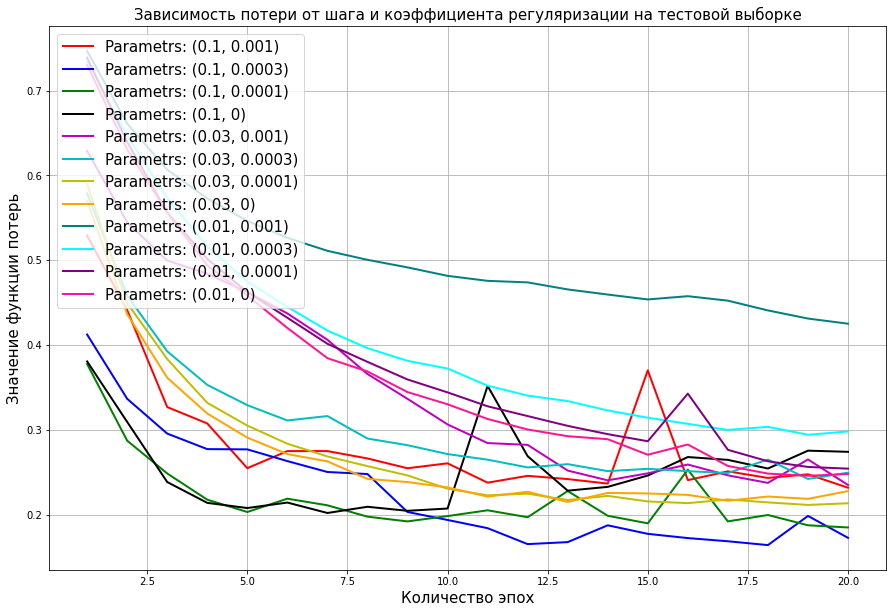

In [24]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и коэффициента регуляризации на тестовой выборке', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
j = 0
for param, loss in test_loss_history_sgd.items():
    plt.plot(range(1, 21), list(map(lambda x: x.item(), loss)), label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15, loc='upper left')
plt.grid(True)

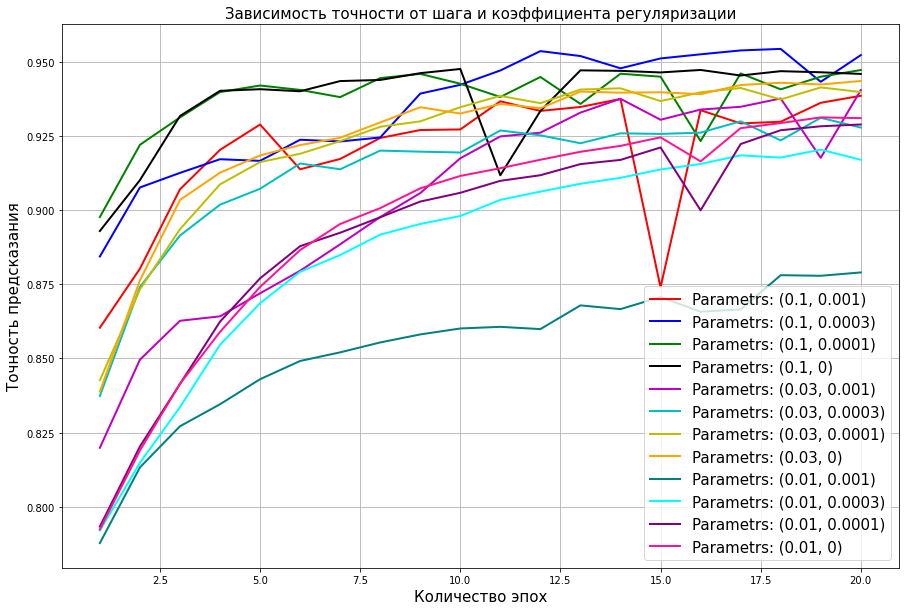

In [23]:
colors = ['r', 'b', 'g', 'k', 'm', 'c', 'y', 'orange', 'teal', 'cyan', 'purple', 'deeppink']

import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость точности от шага и коэффициента регуляризации', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Точность предсказания', fontsize=15)
j = 0
for param, accuracy in test_accuracy_history_sgd.items():
    plt.plot(range(1, 21), accuracy, label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15)
plt.grid(True)

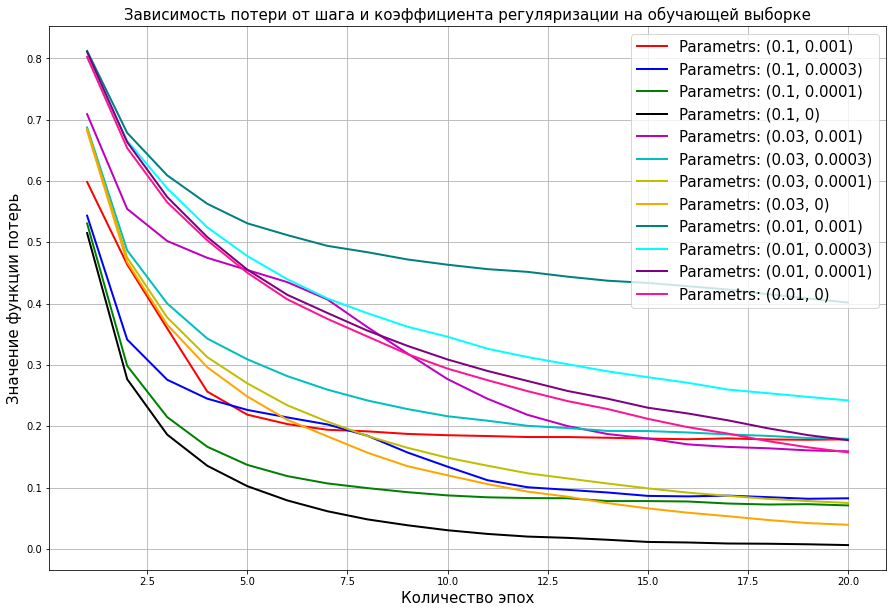

In [25]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и коэффициента регуляризации на обучающей выборке', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
j = 0
for param, loss in loss_in_training_sgd.items():
    plt.plot(range(1, 21), loss, label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15)
plt.grid(True)

In [18]:
test_accuracy_history_sgd, test_loss_history_sgd, loss_in_training_sgd, time_learning_sgd = [], [], [], []

model = BiLSTM(
        num_embeddings=len(token2idx),
        embedding_dim=100,
        hidden_size=100,
        num_layers=1,
        dropout=0.0,
        bidirectional=True,
        n_classes=len(label2idx),
    ).to(device)
    
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=0.0003)
criterion = torch.nn.CrossEntropyLoss(ignore_index=-1)

loss_in_training_sgd, time_learning_sgd, test_accuracy_history_sgd, test_loss_history_sgd = train(20, model, train_dataloader, test_dataloader, optimizer, criterion, device)
with open('sgd_tresults.pkl', 'wb') as f:
    pickle.dump({"acc": test_accuracy_history_sgd, "loss": test_loss_history_sgd, "loss_train":loss_in_training_sgd, "time":time_learning_sgd}, f)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1 / 20]

Train loss: 0.5425982508149096



  5%|▌         | 1/20 [00:26<08:15, 26.05s/it]

Test loss:  0.4811361211051387

Test accuracy: 0.8583976843419666

Epoch [2 / 20]

Train loss: 0.34366764146063533



 10%|█         | 2/20 [00:50<07:36, 25.38s/it]

Test loss:  0.4248508058873744

Test accuracy: 0.8703863866270771

Epoch [3 / 20]

Train loss: 0.2824827583400853



 15%|█▌        | 3/20 [01:16<07:10, 25.32s/it]

Test loss:  0.36241100827419

Test accuracy: 0.8932091239421159

Epoch [4 / 20]

Train loss: 0.2515693310669317



 20%|██        | 4/20 [01:41<06:42, 25.16s/it]

Test loss:  0.35199493263447834

Test accuracy: 0.8927839587269462

Epoch [5 / 20]

Train loss: 0.22678662844445008



 25%|██▌       | 5/20 [02:06<06:16, 25.11s/it]

Test loss:  0.3541587917469535

Test accuracy: 0.8903291911110631

Epoch [6 / 20]

Train loss: 0.21839615990939176



 30%|███       | 6/20 [02:31<05:54, 25.35s/it]

Test loss:  0.3404392929306568

Test accuracy: 0.8918890100557257

Epoch [7 / 20]

Train loss: 0.18474376202385492



 40%|████      | 8/20 [03:23<05:06, 25.55s/it]

Test loss:  0.30254493809142724

Test accuracy: 0.90845171605664

Epoch [9 / 20]

Train loss: 0.15900426615777752



 45%|████▌     | 9/20 [03:48<04:39, 25.41s/it]

Test loss:  0.289743123387609

Test accuracy: 0.9110040123961965

Epoch [10 / 20]

Train loss: 0.13182854385320336



 50%|█████     | 10/20 [04:13<04:11, 25.17s/it]

Test loss:  0.28111280159142055

Test accuracy: 0.9149303258199092

Epoch [11 / 20]

Train loss: 0.11157791835026633



 55%|█████▌    | 11/20 [04:37<03:44, 24.91s/it]

Test loss:  0.27844001616050645

Test accuracy: 0.9220426379275861

Epoch [12 / 20]

Train loss: 0.10118866746300423



 60%|██████    | 12/20 [05:03<03:20, 25.12s/it]

Test loss:  0.2593082453691521

Test accuracy: 0.91919363927692

Epoch [13 / 20]

Train loss: 0.09362542139089723



 65%|██████▌   | 13/20 [05:27<02:53, 24.83s/it]

Test loss:  0.2798067125857006

Test accuracy: 0.911945612451971

Epoch [14 / 20]

Train loss: 0.0919892531209473



 70%|███████   | 14/20 [05:51<02:27, 24.55s/it]

Test loss:  0.26866620124486756

Test accuracy: 0.9148182480711067

Epoch [15 / 20]

Train loss: 0.0878869486049582



 75%|███████▌  | 15/20 [06:16<02:04, 24.84s/it]

Test loss:  0.2525443178451658

Test accuracy: 0.9235455072224933

Epoch [16 / 20]

Train loss: 0.08595441945935746



 80%|████████  | 16/20 [06:42<01:39, 24.97s/it]

Test loss:  0.24325222186033885

Test accuracy: 0.925968221697588

Epoch [17 / 20]

Train loss: 0.08527758441247657



 85%|████████▌ | 17/20 [07:06<01:14, 24.79s/it]

Test loss:  0.2491546253564176

Test accuracy: 0.9277676673250577

Epoch [18 / 20]

Train loss: 0.08476949730443019



 90%|█████████ | 18/20 [07:31<00:49, 24.89s/it]

Test loss:  0.24836249657580198

Test accuracy: 0.9253269655882215

Epoch [19 / 20]

Train loss: 0.08306393832548932



 95%|█████████▌| 19/20 [07:55<00:24, 24.64s/it]

Test loss:  0.24886541060023493

Test accuracy: 0.9254558785173229

Epoch [20 / 20]

Train loss: 0.08402644757721173



100%|██████████| 20/20 [08:19<00:00, 25.00s/it]

Test loss:  0.27182767543349673

Test accuracy: 0.9103301409358127



In [16]:
def train_acc(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: torch.nn.Module,
    device: torch.device,
    acc_max: float
):
    """
    Training loop.
    """
    time_learning = []
    loss_in_training = []
    test_accuracy_history = []
    test_loss_history = []
    acc = 0
    epoch = 0
    while acc < acc_max:

        print(f"Epoch [{epoch+1}]\n")

        train_loss_epoh, time = train_epoch(
            model=model,
            dataloader=train_dataloader,
            optimizer=optimizer,
            criterion=criterion,
            device=device,
            epoch=epoch,
        )
        
        time_learning.append(time)
        loss_in_training.append(train_loss_epoh)
        
        test_loss_epoh, test_accuracy_epoh = evaluate_epoch(
            model=model,
            dataloader=test_dataloader,
            criterion=criterion,
            device=device,
            epoch=epoch,
        )
        acc = test_accuracy_epoh
        test_accuracy_history.append(test_accuracy_epoh)
        test_loss_history.append(test_loss_epoh)
        epoch += 1
        
    return loss_in_training, time_learning, test_accuracy_history, test_loss_history

In [20]:
test_accuracy_history_sgd, test_loss_history_sgd, loss_in_training_sgd, time_learning_sgd = [], [], [], []
acc_max = 0.91
model = BiLSTM(
        num_embeddings=len(token2idx),
        embedding_dim=100,
        hidden_size=100,
        num_layers=1,
        dropout=0.0,
        bidirectional=True,
        n_classes=len(label2idx),
    ).to(device)
    
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=0.0003)
criterion = torch.nn.CrossEntropyLoss(ignore_index=-1)

loss_in_training_sgd, time_learning_sgd, test_accuracy_history_sgd, test_loss_history_sgd = train_acc(model, train_dataloader, test_dataloader, optimizer, criterion, device, acc_max)
with open('sgd_tresults_91.pkl', 'wb') as f:
    pickle.dump({"acc": test_accuracy_history_sgd, "loss": test_loss_history_sgd, "loss_train":loss_in_training_sgd, "time":time_learning_sgd}, f)

Epoch [1]

Train loss: 0.5482138065522693

Test loss:  0.49397796090045437

Test accuracy: 0.8578693254630292

Epoch [2]

Train loss: 0.3432723264583875

Test loss:  0.40381318431865615

Test accuracy: 0.8815908184292056

Epoch [3]

Train loss: 0.28127398793195785

Test loss:  0.3877748586343636

Test accuracy: 0.8865038595931864

Epoch [4]

Train loss: 0.2447436786836461

Test loss:  0.34941484868218464

Test accuracy: 0.8923843199009752

Epoch [5]

Train loss: 0.22660612977841094

Test loss:  0.34291603393060466

Test accuracy: 0.8940931886950326

Epoch [6]

Train loss: 0.21672164495533966

Test loss:  0.3263891612422586

Test accuracy: 0.9021846757042633

Epoch [7]

Train loss: 0.20422627664302817

Test loss:  0.35720259512401914

Test accuracy: 0.8912686094563657

Epoch [8]

Train loss: 0.18530509021785502

Test loss:  0.303998223674168

Test accuracy: 0.9101461504581185



In [19]:
resume = True

if resume: 
    with open('lion_text_results.pkl', 'rb') as f:
        arr = pickle.load(f)
        test_accuracy_history_lion = arr["acc"]
        test_loss_history_lion = arr["loss"]
        loss_in_training_lion = arr["loss_train"]
        time_learning_lion = arr["time"]
else:
    test_accuracy_history_lion, test_loss_history_lion, loss_in_training_lion, time_learning_lion = {}, {}, {}, {}

In [20]:
# for learning_rate, weight_decay in tqdm(product([0.0001, 0.001, 0.01], [1e-3, 3e-4, 1e-4, 0])):
for learning_rate, weight_decay in tqdm(product([0.0005, 0.00005], [0])):
    key = (learning_rate, weight_decay)
    if key in test_accuracy_history_lion:
        print("Already computed, ignoring")
        continue
        
    model = BiLSTM(
        num_embeddings=len(token2idx),
        embedding_dim=100,
        hidden_size=100,
        num_layers=1,
        dropout=0.0,
        bidirectional=True,
        n_classes=len(label2idx),
    ).to(device)
    
    optimizer = Lion(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = torch.nn.CrossEntropyLoss(ignore_index=-1)
    
    loss_in_training_lion[key], time_learning_lion[key], test_accuracy_history_lion[key], test_loss_history_lion[key] = train(20, model, train_dataloader, valid_dataloader, optimizer, criterion, device)
    with open('lion_text_results.pkl', 'wb') as f:
        pickle.dump({"acc": test_accuracy_history_lion, "loss": test_loss_history_lion, "loss_train":loss_in_training_lion, "time":time_learning_lion}, f)

0it [00:00, ?it/s]
  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1 / 20]

Train loss: 0.2603491371942525




  5%|▌         | 1/20 [00:29<09:21, 29.54s/it]

Test loss:  0.20748209397014583

Test accuracy: 0.9376102635519211

Epoch [2 / 20]

Train loss: 0.1298739610505696




 10%|█         | 2/20 [00:58<08:49, 29.42s/it]

Test loss:  0.20349230178700375

Test accuracy: 0.9461796509267825

Epoch [3 / 20]

Train loss: 0.12388055129435865




 15%|█▌        | 3/20 [01:28<08:19, 29.38s/it]

Test loss:  0.20834227559610827

Test accuracy: 0.9435988773210604

Epoch [4 / 20]

Train loss: 0.12280893728760643




 20%|██        | 4/20 [01:57<07:48, 29.26s/it]

Test loss:  0.21614781890402363

Test accuracy: 0.9455699910270787

Epoch [5 / 20]

Train loss: 0.12328893850601484




 25%|██▌       | 5/20 [02:25<07:15, 29.02s/it]

Test loss:  0.2220433349686867

Test accuracy: 0.9432314202556978

Epoch [6 / 20]

Train loss: 0.12374751165002533




 30%|███       | 6/20 [02:55<06:47, 29.13s/it]

Test loss:  0.2117126704838492

Test accuracy: 0.9443766925570333

Epoch [7 / 20]

Train loss: 0.12334813026641808




 35%|███▌      | 7/20 [03:25<06:21, 29.35s/it]

Test loss:  0.21768874367079397

Test accuracy: 0.9440294525279985

Epoch [8 / 20]

Train loss: 0.12467853909417174




 40%|████      | 8/20 [03:55<05:54, 29.57s/it]

Test loss:  0.24361843858498805

Test accuracy: 0.9427593661699026

Epoch [9 / 20]

Train loss: 0.12636864709773726




 45%|████▌     | 9/20 [04:24<05:25, 29.58s/it]

Test loss:  0.23699392435324865

Test accuracy: 0.9432840806772623

Epoch [10 / 20]

Train loss: 0.12703527684307836




 50%|█████     | 10/20 [04:54<04:56, 29.67s/it]

Test loss:  0.25636279915971766

Test accuracy: 0.9418272393456857

Epoch [11 / 20]

Train loss: 0.1273227610767689




 55%|█████▌    | 11/20 [05:24<04:26, 29.63s/it]

Test loss:  0.23788380957404978

Test accuracy: 0.9436113534887703

Epoch [12 / 20]

Train loss: 0.12914435587898784




 60%|██████    | 12/20 [05:53<03:56, 29.55s/it]

Test loss:  0.2229963747440358

Test accuracy: 0.9449420203999169

Epoch [13 / 20]

Train loss: 0.12891280541166034




 65%|██████▌   | 13/20 [06:23<03:27, 29.62s/it]

Test loss:  0.23035896120381355

Test accuracy: 0.9405664218105694

Epoch [14 / 20]

Train loss: 0.13018620330128175




 70%|███████   | 14/20 [06:52<02:56, 29.46s/it]

Test loss:  0.22974980563461433

Test accuracy: 0.9411340361686183

Epoch [15 / 20]

Train loss: 0.12800840437778105




 75%|███████▌  | 15/20 [07:21<02:27, 29.51s/it]

Test loss:  0.232695770034911

Test accuracy: 0.9418778788950827

Epoch [16 / 20]

Train loss: 0.12982080297735712




 80%|████████  | 16/20 [07:51<01:58, 29.61s/it]

Test loss:  0.24036023285541674

Test accuracy: 0.9410477765463733

Epoch [17 / 20]

Train loss: 0.13335266904963727




 85%|████████▌ | 17/20 [08:21<01:28, 29.52s/it]

Test loss:  0.24394410561564137

Test accuracy: 0.9400671256164439

Epoch [18 / 20]

Train loss: 0.13481640866710218




 90%|█████████ | 18/20 [08:50<00:58, 29.42s/it]

Test loss:  0.2393055378837459

Test accuracy: 0.9347222546013643

Epoch [19 / 20]

Train loss: 0.13468836680835855




 95%|█████████▌| 19/20 [09:18<00:29, 29.15s/it]

Test loss:  0.2455158022881084

Test accuracy: 0.9417632227426023

Epoch [20 / 20]

Train loss: 0.13696183419663133




100%|██████████| 20/20 [09:47<00:00, 29.38s/it]
1it [09:50, 590.52s/it]

Test loss:  0.2487271209543701

Test accuracy: 0.9380399230337712




  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1 / 20]

Train loss: 0.4878178672795753




  5%|▌         | 1/20 [00:28<09:08, 28.87s/it]

Test loss:  0.21698545733764124

Test accuracy: 0.9396212197827685

Epoch [2 / 20]

Train loss: 0.10379061981442893




 10%|█         | 2/20 [00:57<08:40, 28.89s/it]

Test loss:  0.15653978535964733

Test accuracy: 0.9555238045040256

Epoch [3 / 20]

Train loss: 0.05710518750292755




 15%|█▌        | 3/20 [01:25<08:05, 28.58s/it]

Test loss:  0.15028313187949843

Test accuracy: 0.96010264845817

Epoch [4 / 20]

Train loss: 0.03457379619324801




 20%|██        | 4/20 [01:54<07:37, 28.57s/it]

Test loss:  0.1649619040565224

Test accuracy: 0.9599499737345943

Epoch [5 / 20]

Train loss: 0.02104211418269169




 25%|██▌       | 5/20 [02:23<07:10, 28.69s/it]

Test loss:  0.18066519211760224

Test accuracy: 0.9578115394794128

Epoch [6 / 20]

Train loss: 0.014617043172508535




 30%|███       | 6/20 [02:52<06:41, 28.66s/it]

Test loss:  0.1970018860076355

Test accuracy: 0.9595006866410873

Epoch [7 / 20]

Train loss: 0.010183717528450976




 35%|███▌      | 7/20 [03:21<06:15, 28.92s/it]

Test loss:  0.22428665289703217

Test accuracy: 0.9580730465624009

Epoch [8 / 20]

Train loss: 0.007822795493240699




 40%|████      | 8/20 [03:50<05:47, 28.96s/it]

Test loss:  0.2384440779996175

Test accuracy: 0.9593141830241478

Epoch [9 / 20]

Train loss: 0.007348051855154694




 45%|████▌     | 9/20 [04:19<05:18, 28.91s/it]

Test loss:  0.24660934834313272

Test accuracy: 0.9603096654848858

Epoch [10 / 20]

Train loss: 0.007411698552599307




 50%|█████     | 10/20 [04:48<04:48, 28.84s/it]

Test loss:  0.26610739800237443

Test accuracy: 0.9581275792174526

Epoch [11 / 20]

Train loss: 0.006452268862719765




 55%|█████▌    | 11/20 [05:16<04:19, 28.83s/it]

Test loss:  0.2459011373133239

Test accuracy: 0.9571669172541585

Epoch [12 / 20]

Train loss: 0.004959551433311515




 60%|██████    | 12/20 [05:45<03:49, 28.75s/it]

Test loss:  0.26102679035387427

Test accuracy: 0.9551278608844995

Epoch [13 / 20]

Train loss: 0.004413736102523812




 65%|██████▌   | 13/20 [06:14<03:21, 28.73s/it]

Test loss:  0.284478919127684

Test accuracy: 0.9601558176130821

Epoch [14 / 20]

Train loss: 0.004727789968240506




 70%|███████   | 14/20 [06:42<02:52, 28.71s/it]

Test loss:  0.2927753892318404

Test accuracy: 0.9572665661789554

Epoch [15 / 20]

Train loss: 0.00462604102200349




 75%|███████▌  | 15/20 [07:10<02:22, 28.55s/it]

Test loss:  0.29925996347825473

Test accuracy: 0.9580129439272096

Epoch [16 / 20]

Train loss: 0.005400383891647433




 80%|████████  | 16/20 [07:39<01:53, 28.48s/it]

Test loss:  0.30230981065083484

Test accuracy: 0.9588269120392414

Epoch [17 / 20]

Train loss: 0.0034674750090715714




 85%|████████▌ | 17/20 [08:08<01:26, 28.74s/it]

Test loss:  0.31623583993748006

Test accuracy: 0.9579671480961015

Epoch [18 / 20]

Train loss: 0.004778705224234663




 90%|█████████ | 18/20 [08:37<00:57, 28.87s/it]

Test loss:  0.2926489657348249

Test accuracy: 0.9564993582985852

Epoch [19 / 20]

Train loss: 0.004279614602763997




 95%|█████████▌| 19/20 [09:06<00:28, 28.85s/it]

Test loss:  0.30898322522102134

Test accuracy: 0.9560425467114589

Epoch [20 / 20]

Train loss: 0.0036081832248112365




100%|██████████| 20/20 [09:35<00:00, 28.76s/it]
2it [19:25, 582.91s/it]

Test loss:  0.31353887417512805

Test accuracy: 0.958061078262463



In [21]:
del test_accuracy_history_lion[(0.01, 1e-3)]
del test_accuracy_history_lion[(0.01, 3e-4)]
del test_accuracy_history_lion[(0.01, 1e-4)]
del test_accuracy_history_lion[(0.01, 0)]

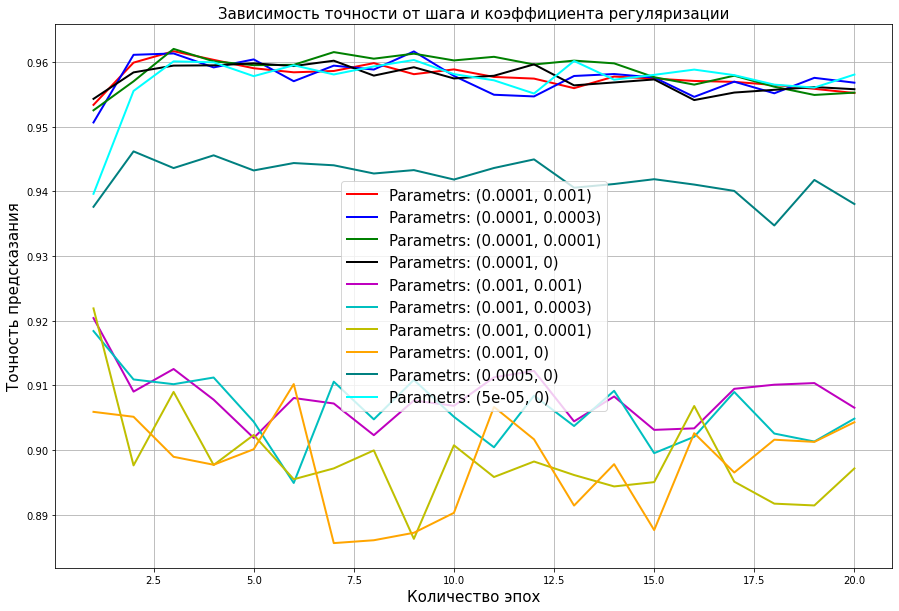

In [25]:
colors = ['r', 'b', 'g', 'k', 'm', 'c', 'y', 'orange', 'teal', 'cyan', 'purple', 'deeppink']

import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость точности от шага и коэффициента регуляризации', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Точность предсказания', fontsize=15)
j = 0
for param, accuracy in test_accuracy_history_lion.items():
    plt.plot(range(1, 21), accuracy, label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15)
plt.grid(True)

In [23]:
del test_loss_history_lion[(0.01, 1e-3)]
del test_loss_history_lion[(0.01, 3e-4)]
del test_loss_history_lion[(0.01, 1e-4)]
del test_loss_history_lion[(0.01, 0)]

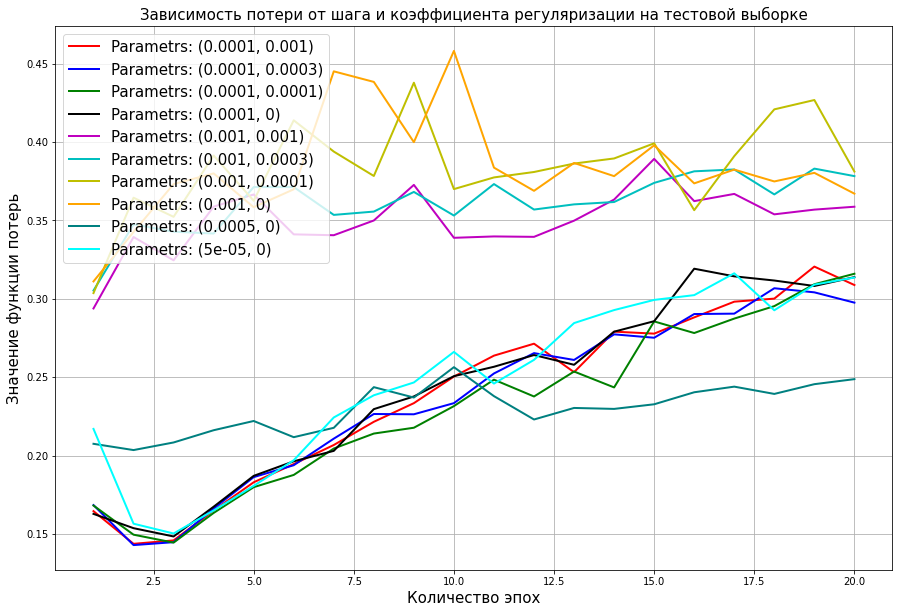

In [26]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и коэффициента регуляризации на тестовой выборке', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
j = 0
for param, loss in test_loss_history_lion.items():
    plt.plot(range(1, 21), list(map(lambda x: x.item(), loss)), label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15, loc='upper left')
plt.grid(True)

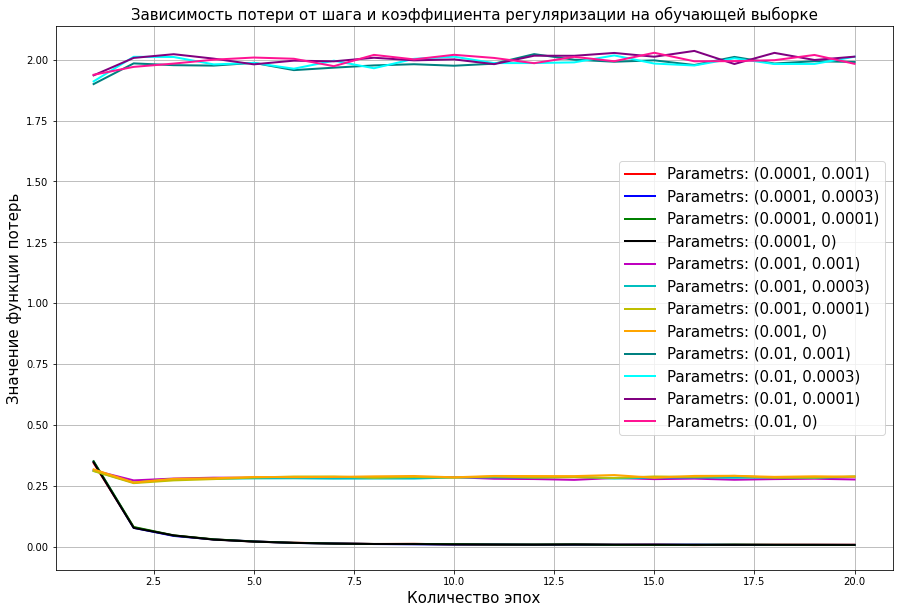

In [31]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и коэффициента регуляризации на обучающей выборке', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
j = 0
for param, loss in loss_in_training_lion.items():
    plt.plot(range(1, 21), loss, label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15)
plt.grid(True)

In [32]:
test_accuracy_history_lion, test_loss_history_lion, loss_in_training_lion, time_learning_lion = [], [], [], []

model = BiLSTM(
        num_embeddings=len(token2idx),
        embedding_dim=100,
        hidden_size=100,
        num_layers=1,
        dropout=0.0,
        bidirectional=True,
        n_classes=len(label2idx),
    ).to(device)
    
optimizer = Lion(model.parameters(), lr=0.0001, weight_decay=0.001)
criterion = torch.nn.CrossEntropyLoss(ignore_index=-1)

loss_in_training_lion, time_learning_lion, test_accuracy_history_lion, test_loss_history_lion = train(20, model, train_dataloader, test_dataloader, optimizer, criterion, device)
with open('lion_tresults.pkl', 'wb') as f:
    pickle.dump({"acc": test_accuracy_history_lion, "loss": test_loss_history_lion, "loss_train":loss_in_training_lion, "time":time_learning_lion}, f)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1 / 20]

Train loss: 0.35221584490685276



  5%|▌         | 1/20 [00:30<09:40, 30.58s/it]

Test loss:  0.26488819262403723

Test accuracy: 0.9233811971345504

Epoch [2 / 20]

Train loss: 0.08067899060345284



 10%|█         | 2/20 [01:01<09:09, 30.52s/it]

Test loss:  0.2764466373535532

Test accuracy: 0.9266709574407455

Epoch [3 / 20]

Train loss: 0.04642067211612668



 15%|█▌        | 3/20 [01:30<08:28, 29.88s/it]

Test loss:  0.28817250550329515

Test accuracy: 0.9259900297106477

Epoch [4 / 20]

Train loss: 0.03011139973636341



 20%|██        | 4/20 [02:00<08:00, 30.03s/it]

Test loss:  0.29613305483266966

Test accuracy: 0.931902899154504

Epoch [5 / 20]

Train loss: 0.021906358385722708



 25%|██▌       | 5/20 [02:29<07:24, 29.65s/it]

Test loss:  0.33893134426864735

Test accuracy: 0.927224088967824

Epoch [6 / 20]

Train loss: 0.017094409395332723



 30%|███       | 6/20 [02:57<06:49, 29.28s/it]

Test loss:  0.364255570828067

Test accuracy: 0.9310011484484343

Epoch [7 / 20]

Train loss: 0.013702554434347895



 35%|███▌      | 7/20 [03:27<06:22, 29.43s/it]

Test loss:  0.38843810893488806

Test accuracy: 0.9237551338014978

Epoch [8 / 20]

Train loss: 0.012465742537593258



 40%|████      | 8/20 [03:58<05:56, 29.73s/it]

Test loss:  0.42631587511422453

Test accuracy: 0.9320168627395424

Epoch [9 / 20]

Train loss: 0.010893489287601164



 45%|████▌     | 9/20 [04:29<05:32, 30.23s/it]

Test loss:  0.4226943592929328

Test accuracy: 0.930186270219335

Epoch [10 / 20]

Train loss: 0.0103269492455518



 50%|█████     | 10/20 [04:59<05:00, 30.05s/it]

Test loss:  0.4644572289644768

Test accuracy: 0.9309733864758964

Epoch [11 / 20]

Train loss: 0.010166994838116642



 55%|█████▌    | 11/20 [05:29<04:31, 30.18s/it]

Test loss:  0.4768108351825399

Test accuracy: 0.9277427125910638

Epoch [12 / 20]

Train loss: 0.009550638339540516



 60%|██████    | 12/20 [05:59<03:59, 29.99s/it]

Test loss:  0.5165228339904415

Test accuracy: 0.9265682269646248

Epoch [13 / 20]

Train loss: 0.00842605275858055



 65%|██████▌   | 13/20 [06:30<03:32, 30.33s/it]

Test loss:  0.5212525713373548

Test accuracy: 0.9183664419031179

Epoch [14 / 20]

Train loss: 0.00853561775489434



 70%|███████   | 14/20 [07:01<03:03, 30.56s/it]

Test loss:  0.5288090456931015

Test accuracy: 0.9198085061486401

Epoch [15 / 20]

Train loss: 0.009794059884684321



 75%|███████▌  | 15/20 [07:30<02:30, 30.06s/it]

Test loss:  0.5229958228104362

Test accuracy: 0.9300012595916971

Epoch [16 / 20]

Train loss: 0.008559516641722569



 80%|████████  | 16/20 [07:59<01:58, 29.69s/it]

Test loss:  0.5446718475974265

Test accuracy: 0.9256944549529769

Epoch [17 / 20]

Train loss: 0.00954756480518822



 85%|████████▌ | 17/20 [08:28<01:29, 29.72s/it]

Test loss:  0.525065183519252

Test accuracy: 0.9227286996559452

Epoch [18 / 20]

Train loss: 0.009112173926770235



 90%|█████████ | 18/20 [08:57<00:58, 29.43s/it]

Test loss:  0.5774773685114984

Test accuracy: 0.9200751446920018

Epoch [19 / 20]

Train loss: 0.008242643821688128



 95%|█████████▌| 19/20 [09:28<00:29, 29.85s/it]

Test loss:  0.5803684167192884

Test accuracy: 0.9187731124957802

Epoch [20 / 20]

Train loss: 0.009162597922602388



100%|██████████| 20/20 [09:58<00:00, 29.91s/it]

Test loss:  0.5959045614747203

Test accuracy: 0.9251032274995381



In [33]:
test_accuracy_history_lion, test_loss_history_lion, loss_in_training_lion, time_learning_lion = [], [], [], []

model = BiLSTM(
        num_embeddings=len(token2idx),
        embedding_dim=100,
        hidden_size=100,
        num_layers=1,
        dropout=0.0,
        bidirectional=True,
        n_classes=len(label2idx),
    ).to(device)
    
optimizer = Lion(model.parameters(), lr=0.0001, weight_decay=0.001)
criterion = torch.nn.CrossEntropyLoss(ignore_index=-1)

loss_in_training_lion, time_learning_lion, test_accuracy_history_lion, test_loss_history_lion = train_acc(model, train_dataloader, test_dataloader, optimizer, criterion, device, acc_max)
with open('lion_tresults_91.pkl', 'wb') as f:
    pickle.dump({"acc": test_accuracy_history_lion, "loss": test_loss_history_lion, "loss_train":loss_in_training_lion, "time":time_learning_lion}, f)

Epoch [1]

Train loss: 0.34157474513475317

Test loss:  0.2636331848706947

Test accuracy: 0.9262497890751094



In [34]:
def train_epoch(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: torch.nn.Module,
    device: torch.device,
    epoch: int,
):
    """
    One training cycle (loop).
    """

    model.train()

    epoch_loss = []
    start_time = times.time()
    
    for i, (tokens, labels) in enumerate(dataloader):

        tokens, labels = tokens.to(device), labels.to(device)

        # YOUR CODE HERE
        # Подсчет лосса и шаг оптимизатора
        # model.zero_grad()
        outputs = model(tokens)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.first_step(zero_grad=True)
        
        outputs = model(tokens)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.second_step(zero_grad=True)
        
        epoch_loss.append(loss.item())
    
    time = times.time() - start_time
    avg_loss = np.mean(epoch_loss)
    print(f"Train loss: {avg_loss}\n")
    
    return avg_loss, time

In [35]:
resume = True

if resume: 
    with open('sam_text_results.pkl', 'rb') as f:
        arr = pickle.load(f)
        test_accuracy_history_sam = arr["acc"]
        test_loss_history_sam = arr["loss"]
        loss_in_training_sam = arr["loss_train"]
        time_learning_sam = arr["time"]
else:
    test_accuracy_history_sam, test_loss_history_sam, loss_in_training_sam, time_learning_sam = {}, {}, {}, {}

In [36]:
import warnings
warnings.filterwarnings("ignore")

In [37]:
for learning_rate, weight_decay in tqdm(product([0.1, 0.03, 0.01], [1e-3, 3e-4, 1e-4, 0])):
    key = (learning_rate, weight_decay)
    if key in test_accuracy_history_sam:
        print("Already computed, ignoring")
        continue
    
    model = BiLSTM(
        num_embeddings=len(token2idx),
        embedding_dim=100,
        hidden_size=100,
        num_layers=1,
        dropout=0.0,
        bidirectional=True,
        n_classes=len(label2idx),
    ).to(device)
    
    base_optimizer = torch.optim.SGD
    optimizer = SAM(model.parameters(), base_optimizer, lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
    criterion = torch.nn.CrossEntropyLoss(ignore_index=-1)
    
    loss_in_training_sam[key], time_learning_sam[key], test_accuracy_history_sam[key], test_loss_history_sam[key] = train(20, model, train_dataloader, valid_dataloader, optimizer, criterion, device)
    with open('sam_text_results.pkl', 'wb') as f:
        pickle.dump({"acc": test_accuracy_history_sam, "loss": test_loss_history_sam, "loss_train":loss_in_training_sam, "time":time_learning_sam}, f)

12it [00:00, 14078.78it/s]

Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring


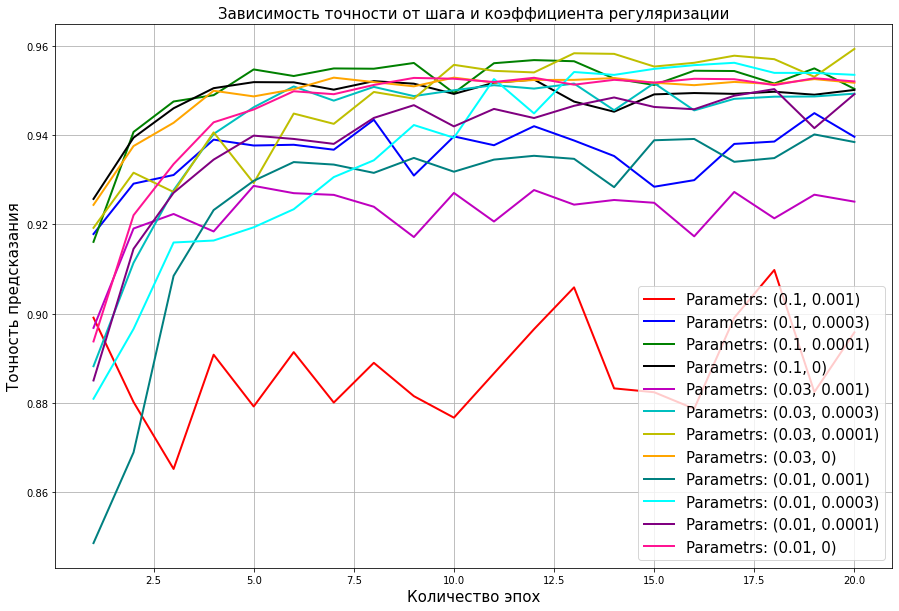

In [23]:
colors = ['r', 'b', 'g', 'k', 'm', 'c', 'y', 'orange', 'teal', 'cyan', 'purple', 'deeppink']

import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость точности от шага и коэффициента регуляризации', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Точность предсказания', fontsize=15)
j = 0
for param, accuracy in test_accuracy_history_sam.items():
    plt.plot(range(1, 21), accuracy, label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15)
plt.grid(True)
# plt.savefig('sgd_1_accrucy.png')

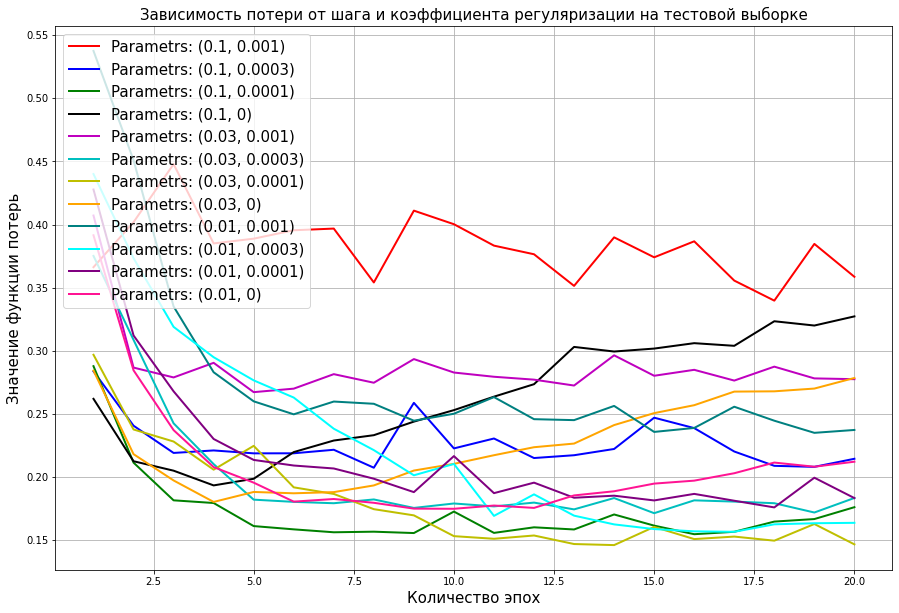

In [24]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и коэффициента регуляризации на тестовой выборке', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
j = 0
for param, loss in test_loss_history_sam.items():
    plt.plot(range(1, 21), list(map(lambda x: x.item(), loss)), label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15, loc='upper left')
plt.grid(True)

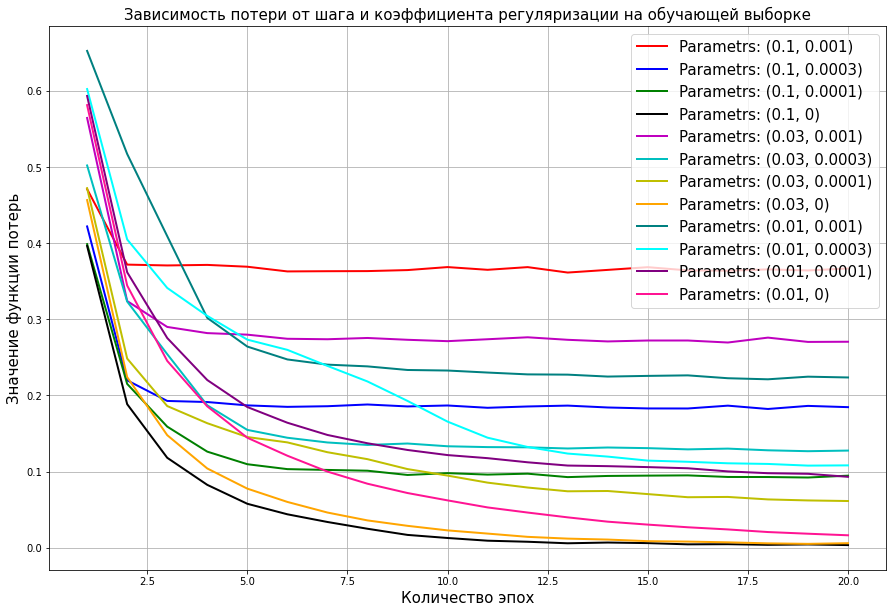

In [25]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и коэффициента регуляризации на обучающей выборке', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
j = 0
for param, loss in loss_in_training_sam.items():
    plt.plot(range(1, 21), loss, label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15)
plt.grid(True)

In [20]:
resume = True

if resume: 
    with open('sam_rho_text_results.pkl', 'rb') as f:
        arr = pickle.load(f)
        test_accuracy_history_sam = arr["acc"]
        test_loss_history_sam = arr["loss"]
        loss_in_training_sam = arr["loss_train"]
        time_learning_sam = arr["time"]
else:
    test_accuracy_history_sam, test_loss_history_sam, loss_in_training_sam, time_learning_sam = {}, {}, {}, {}

In [21]:
for p in tqdm([0.01, 0.02, 0.05, 0.1, 0.2, 0.5]):
    key = p
    if key in test_accuracy_history_sam:
        print("Already computed, ignoring")
        continue   
    
    model = BiLSTM(
        num_embeddings=len(token2idx),
        embedding_dim=100,
        hidden_size=100,
        num_layers=1,
        dropout=0.0,
        bidirectional=True,
        n_classes=len(label2idx),
    ).to(device)
    
    base_optimizer = torch.optim.SGD
    optimizer = SAM(model.parameters(), base_optimizer, rho=p, lr=0.03, momentum=0.9, weight_decay=0.0001)
    criterion = torch.nn.CrossEntropyLoss(ignore_index=-1)
    
    loss_in_training_sam[key], time_learning_sam[key], test_accuracy_history_sam[key], test_loss_history_sam[key] = train(20, model, train_dataloader, valid_dataloader, optimizer, criterion, device)
    with open('sam_rho_text_results.pkl', 'wb') as f:
        pickle.dump({"acc": test_accuracy_history_sam, "loss": test_loss_history_sam, "loss_train":loss_in_training_sam, "time":time_learning_sam}, f)

100%|██████████| 6/6 [00:00<00:00, 17391.72it/s]

Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring


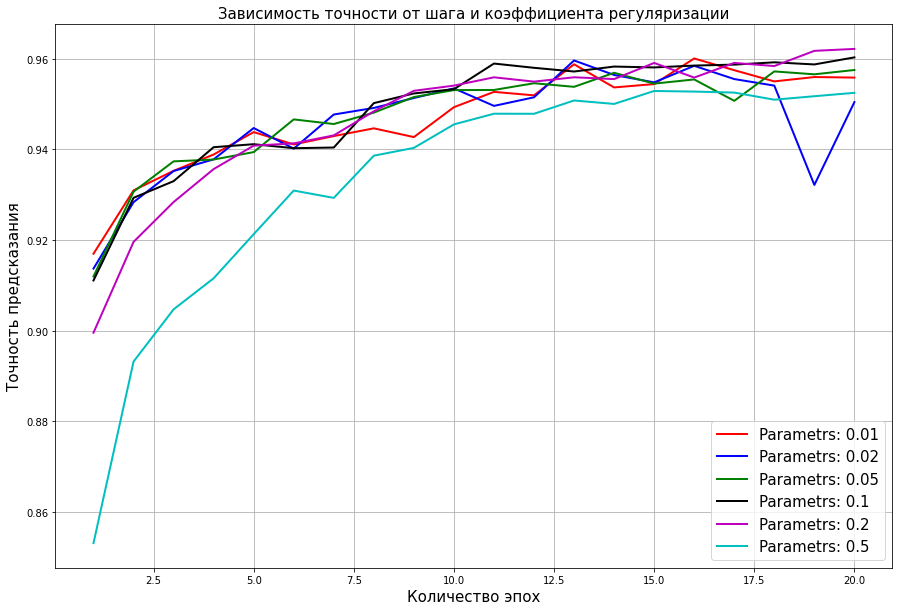

In [24]:
colors = ['r', 'b', 'g', 'k', 'm', 'c', 'y', 'orange', 'teal', 'cyan', 'purple', 'deeppink']

import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость точности от шага и коэффициента регуляризации', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Точность предсказания', fontsize=15)
j = 0
for param, accuracy in test_accuracy_history_sam.items():
    plt.plot(range(1, 21), accuracy, label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15)
plt.grid(True)

In [38]:
model = BiLSTM(
        num_embeddings=len(token2idx),
        embedding_dim=100,
        hidden_size=100,
        num_layers=1,
        dropout=0.0,
        bidirectional=True,
        n_classes=len(label2idx),
    ).to(device)
    
base_optimizer = torch.optim.SGD
optimizer = SAM(model.parameters(), base_optimizer, rho=0.1, lr=0.03, momentum=0.9, weight_decay=0.0001)
criterion = torch.nn.CrossEntropyLoss(ignore_index=-1)

loss_in_training_sam, time_learning_sam, test_accuracy_history_sam, test_loss_history_sam = train(20, model, train_dataloader, test_dataloader, optimizer, criterion, device)
with open('sam_tresults.pkl', 'wb') as f:
    pickle.dump({"acc": test_accuracy_history_sam, "loss": test_loss_history_sam, "loss_train":loss_in_training_sam, "time":time_learning_sam}, f)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1 / 20]

Train loss: 0.5177228737582695



  5%|▌         | 1/20 [00:58<18:22, 58.05s/it]

Test loss:  0.38431013304527273

Test accuracy: 0.8878562335501895

Epoch [2 / 20]

Train loss: 0.29699770480724796



 10%|█         | 2/20 [01:52<16:50, 56.13s/it]

Test loss:  0.3339966067182111

Test accuracy: 0.8994083784182428

Epoch [3 / 20]

Train loss: 0.2296780016282683



 15%|█▌        | 3/20 [02:47<15:39, 55.29s/it]

Test loss:  0.32153730867709673

Test accuracy: 0.9004834329797139

Epoch [4 / 20]

Train loss: 0.19600503076146292



 20%|██        | 4/20 [03:44<14:57, 56.09s/it]

Test loss:  0.29851674955822677

Test accuracy: 0.903588420580508

Epoch [5 / 20]

Train loss: 0.17727633017683403



 25%|██▌       | 5/20 [04:41<14:07, 56.49s/it]

Test loss:  0.28670047431664697

Test accuracy: 0.9125792747516882

Epoch [6 / 20]

Train loss: 0.16307313390223083



 30%|███       | 6/20 [05:38<13:14, 56.73s/it]

Test loss:  0.2899088374521435

Test accuracy: 0.9121504760801568

Epoch [7 / 20]

Train loss: 0.15233757625296973



 35%|███▌      | 7/20 [06:34<12:13, 56.42s/it]

Test loss:  0.26519886923092173

Test accuracy: 0.9210858208704574

Epoch [8 / 20]

Train loss: 0.13624181855668904



 40%|████      | 8/20 [07:25<10:56, 54.74s/it]

Test loss:  0.2641505311356585

Test accuracy: 0.9179918464773122

Epoch [9 / 20]

Train loss: 0.12399012574703348



 45%|████▌     | 9/20 [08:17<09:51, 53.78s/it]

Test loss:  0.27197042789066894

Test accuracy: 0.9188538753557094

Epoch [10 / 20]

Train loss: 0.11267366995029221



 50%|█████     | 10/20 [09:09<08:51, 53.13s/it]

Test loss:  0.24551602730722008

Test accuracy: 0.9260335875708966

Epoch [11 / 20]

Train loss: 0.10234936912155254



 55%|█████▌    | 11/20 [10:01<07:56, 52.93s/it]

Test loss:  0.24458376051529462

Test accuracy: 0.9246416013575902

Epoch [12 / 20]

Train loss: 0.09551901561664533



 60%|██████    | 12/20 [10:54<07:02, 52.78s/it]

Test loss:  0.24148513053824844

Test accuracy: 0.9285201181643443

Epoch [13 / 20]

Train loss: 0.09263363383903053



 65%|██████▌   | 13/20 [11:46<06:08, 52.59s/it]

Test loss:  0.2313500685109445

Test accuracy: 0.932691937212536

Epoch [14 / 20]

Train loss: 0.08728397136800718



 70%|███████   | 14/20 [12:36<05:11, 51.88s/it]

Test loss:  0.24300996967966274

Test accuracy: 0.9290131180960577

Epoch [15 / 20]

Train loss: 0.08467385838809138



 75%|███████▌  | 15/20 [13:27<04:18, 51.78s/it]

Test loss:  0.2303529212269694

Test accuracy: 0.9317572517442012

Epoch [16 / 20]

Train loss: 0.08192486173340181



 80%|████████  | 16/20 [14:18<03:25, 51.45s/it]

Test loss:  0.233369309900343

Test accuracy: 0.9330927744018109

Epoch [17 / 20]

Train loss: 0.08152207809466962



 85%|████████▌ | 17/20 [15:11<02:35, 51.81s/it]

Test loss:  0.23357835284432654

Test accuracy: 0.9312270041936173

Epoch [18 / 20]

Train loss: 0.0779728814671498



 90%|█████████ | 18/20 [16:04<01:44, 52.35s/it]

Test loss:  0.25328418136328895

Test accuracy: 0.9271121441665999

Epoch [19 / 20]

Train loss: 0.07898191248307726



 95%|█████████▌| 19/20 [16:57<00:52, 52.44s/it]

Test loss:  0.23301594516448604

Test accuracy: 0.9317329416067488

Epoch [20 / 20]

Train loss: 0.07654939194975834



100%|██████████| 20/20 [17:47<00:00, 53.39s/it]

Test loss:  0.23069790734706405

Test accuracy: 0.9337884388776261



In [39]:
acc_max = 0.91
model = BiLSTM(
        num_embeddings=len(token2idx),
        embedding_dim=100,
        hidden_size=100,
        num_layers=1,
        dropout=0.0,
        bidirectional=True,
        n_classes=len(label2idx),
    ).to(device)
    
base_optimizer = torch.optim.SGD
optimizer = SAM(model.parameters(), base_optimizer, rho=0.1, lr=0.03, momentum=0.9, weight_decay=0.0001)
criterion = torch.nn.CrossEntropyLoss(ignore_index=-1)

loss_in_training_sam, time_learning_sam, test_accuracy_history_sam, test_loss_history_sam = train_acc(model, train_dataloader, test_dataloader, optimizer, criterion, device, acc_max)
with open('sam_tresults_91.pkl', 'wb') as f:
    pickle.dump({"acc": test_accuracy_history_sam, "loss": test_loss_history_sam, "loss_train":loss_in_training_sam, "time":time_learning_sam}, f)

Epoch [1]

Train loss: 0.5172080026743626

Test loss:  0.3919483253768611

Test accuracy: 0.887587724916565

Epoch [2]

Train loss: 0.2946775084212656

Test loss:  0.33288478664551263

Test accuracy: 0.9012697065971407

Epoch [3]

Train loss: 0.22558882371062294

Test loss:  0.3096155007423551

Test accuracy: 0.9040076592406577

Epoch [4]

Train loss: 0.1891276964308871

Test loss:  0.3143423740130327

Test accuracy: 0.9043500338907631

Epoch [5]

Train loss: 0.17553607424377748

Test loss:  0.2914272232708936

Test accuracy: 0.9134729974010297



In [40]:
def train_epoch(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    preconditioner,
    criterion: torch.nn.Module,
    device: torch.device,
    epoch: int,
):
    """
    One training cycle (loop).
    """

    model.train()

    epoch_loss = []
    start_time = times.time()
    
    for i, (tokens, labels) in enumerate(dataloader):

        tokens, labels = tokens.to(device), labels.to(device)

        # YOUR CODE HERE
        # Подсчет лосса и шаг оптимизатора
        model.zero_grad()
        outputs = model(tokens)
        loss = criterion(outputs, labels)
        loss.backward()
        try:
            preconditioner.step()
            optimizer.step()
        except:
            print("Optimizer or preconditioner step failed")
            pass
        
        epoch_loss.append(loss.item())
    
    time = times.time() - start_time
    avg_loss = np.mean(epoch_loss)
    print(f"Train loss: {avg_loss}\n")
    
    return avg_loss, time

In [41]:
def train(
    n_epochs: int,
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    preconditioner,
    criterion: torch.nn.Module,
    device: torch.device,
):
    """
    Training loop.
    """
    time_learning = []
    loss_in_training = []
    test_accuracy_history = []
    test_loss_history = []
    
    for epoch in tqdm(range(n_epochs)):

        print(f"Epoch [{epoch+1} / {n_epochs}]\n")

        train_loss_epoh, time = train_epoch(
            model=model,
            dataloader=train_dataloader,
            optimizer=optimizer,
            preconditioner=preconditioner,
            criterion=criterion,
            device=device,
            epoch=epoch,
        )
        
        time_learning.append(time)
        loss_in_training.append(train_loss_epoh)
        
        test_loss_epoh, test_accuracy_epoh = evaluate_epoch(
            model=model,
            dataloader=test_dataloader,
            criterion=criterion,
            device=device,
            epoch=epoch,
        )
        
        test_accuracy_history.append(test_accuracy_epoh)
        test_loss_history.append(test_loss_epoh)
        
    return loss_in_training, time_learning, test_accuracy_history, test_loss_history

In [24]:
resume = True

if resume: 
    with open('kfc_text_results.pkl', 'rb') as f:
        arr = pickle.load(f)
        test_accuracy_history_kfc = arr["acc"]
        test_loss_history_kfc = arr["loss"]
        loss_in_training_kfc = arr["loss_train"]
        time_learning_kfc = arr["time"]
else:
    test_accuracy_history_kfc, test_loss_history_kfc, loss_in_training_kfc, time_learning_kfc = {}, {}, {}, {}

In [25]:
for learning_rate, weight_decay in tqdm(product([0.1, 0.03, 0.01], [1e-3, 3e-4, 1e-4, 0])):
    key = (learning_rate, weight_decay)
    if key in test_accuracy_history_kfc:
        print("Already computed, ignoring")
        continue
    
    model = BiLSTM(
        num_embeddings=len(token2idx),
        embedding_dim=100,
        hidden_size=100,
        num_layers=1,
        dropout=0.0,
        bidirectional=True,
        n_classes=len(label2idx),
    ).to(device)
    
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    preconditioner = KFACPreconditioner(model)
    criterion = torch.nn.CrossEntropyLoss(ignore_index=-1)
    
    loss_in_training_kfc[key], time_learning_kfc[key], test_accuracy_history_kfc[key], test_loss_history_kfc[key] = train(20, model, train_dataloader, valid_dataloader, optimizer, preconditioner, criterion, device)
    with open('kfc_text_results.pkl', 'wb') as f:
        pickle.dump({"acc": test_accuracy_history_kfc, "loss": test_loss_history_kfc, "loss_train":loss_in_training_kfc, "time":time_learning_kfc}, f)

12it [00:00, 27458.62it/s]

Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring


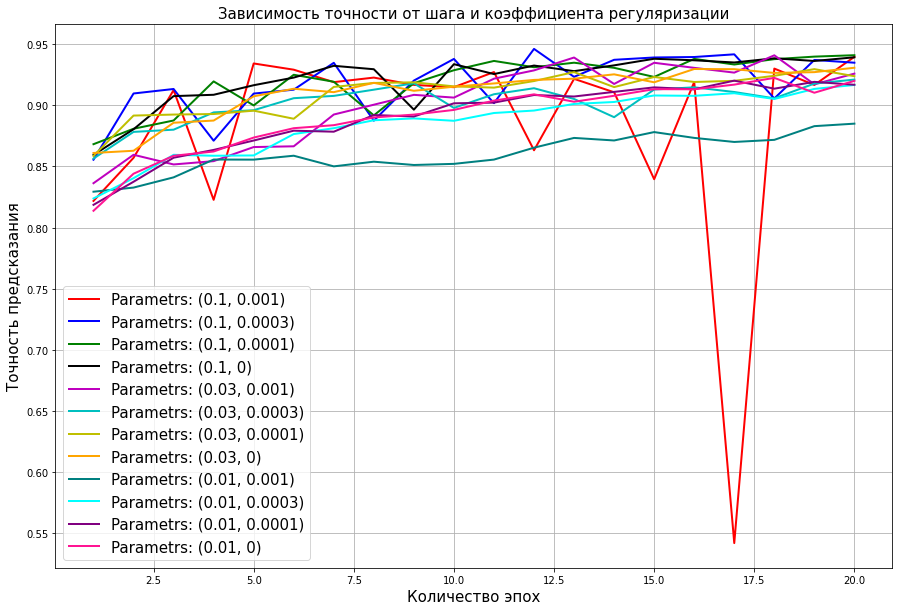

In [26]:
colors = ['r', 'b', 'g', 'k', 'm', 'c', 'y', 'orange', 'teal', 'cyan', 'purple', 'deeppink']

import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость точности от шага и коэффициента регуляризации', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Точность предсказания', fontsize=15)
j = 0
for param, accuracy in test_accuracy_history_kfc.items():
    plt.plot(range(1, 21), accuracy, label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15)
plt.grid(True)

In [42]:
model = BiLSTM(
    num_embeddings=len(token2idx),
    embedding_dim=100,
    hidden_size=100,
    num_layers=1,
    dropout=0.0,
    bidirectional=True,
    n_classes=len(label2idx),
).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.03, weight_decay=0.001)
preconditioner = KFACPreconditioner(model)
criterion = torch.nn.CrossEntropyLoss(ignore_index=-1)

loss_in_training_kfc, time_learning_kfc, test_accuracy_history_kfc, test_loss_history_kfc = train(20, model, train_dataloader, test_dataloader, optimizer, preconditioner, criterion, device)
with open('kfc_tresults.pkl', 'wb') as f:
    pickle.dump({"acc": test_accuracy_history_kfc, "loss": test_loss_history_kfc, "loss_train":loss_in_training_kfc, "time":time_learning_kfc}, f)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1 / 20]

Train loss: 0.618347881554138



  5%|▌         | 1/20 [01:05<20:47, 65.67s/it]

Test loss:  0.5902782905172113

Test accuracy: 0.8253536969858006

Epoch [2 / 20]

Train loss: 0.500294742936716



 10%|█         | 2/20 [02:12<19:53, 66.29s/it]

Test loss:  0.5962796496450415

Test accuracy: 0.8335745126749372

Epoch [3 / 20]

Train loss: 0.48204597403875565



 15%|█▌        | 3/20 [03:19<18:53, 66.65s/it]

Test loss:  0.5623326175258669

Test accuracy: 0.8405290552398248

Epoch [4 / 20]

Train loss: 0.4727146788949333



 20%|██        | 4/20 [04:29<18:10, 68.17s/it]

Test loss:  0.5575727285211415

Test accuracy: 0.8448879170728362

Epoch [5 / 20]

Train loss: 0.445879509041164



 25%|██▌       | 5/20 [05:37<17:00, 68.05s/it]

Test loss:  0.5761043925715675

Test accuracy: 0.8432011300983187

Epoch [6 / 20]

Train loss: 0.4419917486362225



 30%|███       | 6/20 [06:46<15:53, 68.11s/it]

Test loss:  0.4964663319358034

Test accuracy: 0.8624666221494408

Epoch [7 / 20]

Train loss: 0.4075896342642753



 35%|███▌      | 7/20 [07:56<14:54, 68.77s/it]

Test loss:  0.49712919720515963

Test accuracy: 0.8535448836922738

Epoch [8 / 20]

Train loss: 0.3765421572137846



 40%|████      | 8/20 [09:04<13:43, 68.61s/it]

Test loss:  0.4572120664692254

Test accuracy: 0.8644835680334685

Epoch [9 / 20]

Train loss: 0.3401857793909253



 45%|████▌     | 9/20 [10:12<12:31, 68.29s/it]

Test loss:  0.502483812605547

Test accuracy: 0.8673804751851524

Epoch [10 / 20]

Train loss: 0.30369835188000277



 50%|█████     | 10/20 [11:23<11:32, 69.30s/it]

Test loss:  0.41385831550634217

Test accuracy: 0.8896126424437344

Epoch [11 / 20]

Train loss: 0.2676678862326906



 55%|█████▌    | 11/20 [12:33<10:26, 69.62s/it]

Test loss:  0.3862470474425268

Test accuracy: 0.8903860686682794

Epoch [12 / 20]

Train loss: 0.23915508353712886



 60%|██████    | 12/20 [13:44<09:18, 69.83s/it]

Test loss:  0.44498837255837537

Test accuracy: 0.8870191586752884

Epoch [13 / 20]

Train loss: 0.21857885942113509



 65%|██████▌   | 13/20 [14:55<08:12, 70.32s/it]

Test loss:  0.3522516758242128

Test accuracy: 0.9043316688448665

Epoch [14 / 20]

Train loss: 0.20546056804507984



 70%|███████   | 14/20 [16:04<06:59, 69.96s/it]

Test loss:  0.4901769581429167

Test accuracy: 0.8716893486696677

Epoch [15 / 20]

Train loss: 0.19850140210826298



 75%|███████▌  | 15/20 [17:13<05:47, 69.57s/it]

Test loss:  0.3860849667092988

Test accuracy: 0.9024907000002632

Epoch [16 / 20]

Train loss: 0.18578561057501658



 80%|████████  | 16/20 [18:23<04:38, 69.72s/it]

Test loss:  1.0268429584155137

Test accuracy: 0.8063798236056036

Epoch [17 / 20]

Train loss: 0.1865664205416934



 85%|████████▌ | 17/20 [19:32<03:28, 69.48s/it]

Test loss:  0.3449293951401692

Test accuracy: 0.9134461222929516

Epoch [18 / 20]

Train loss: 0.17576565402590835



 90%|█████████ | 18/20 [20:42<02:19, 69.68s/it]

Test loss:  0.3275353625177825

Test accuracy: 0.9139274962647782

Epoch [19 / 20]

Train loss: 0.1668450426893503



 95%|█████████▌| 19/20 [21:52<01:09, 69.65s/it]

Test loss:  0.4329557328815666

Test accuracy: 0.904071070574635

Epoch [20 / 20]

Train loss: 0.16965310196136651



100%|██████████| 20/20 [22:59<00:00, 68.99s/it]

Test loss:  0.45644389836303323

Test accuracy: 0.8880208505856414



In [43]:
def train_acc(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    preconditioner,
    criterion: torch.nn.Module,
    device: torch.device,
    acc_max: float
):
    """
    Training loop.
    """
    time_learning = []
    loss_in_training = []
    test_accuracy_history = []
    test_loss_history = []
    acc = 0
    epoch = 0
    while acc < acc_max:

        print(f"Epoch [{epoch+1}]\n")

        train_loss_epoh, time = train_epoch(
            model=model,
            dataloader=train_dataloader,
            optimizer=optimizer,
            preconditioner=preconditioner,
            criterion=criterion,
            device=device,
            epoch=epoch,
        )
        
        time_learning.append(time)
        loss_in_training.append(train_loss_epoh)
        
        test_loss_epoh, test_accuracy_epoh = evaluate_epoch(
            model=model,
            dataloader=test_dataloader,
            criterion=criterion,
            device=device,
            epoch=epoch,
        )
        
        acc = test_accuracy_epoh
        test_accuracy_history.append(test_accuracy_epoh)
        test_loss_history.append(test_loss_epoh)
        epoch += 1
        
    return loss_in_training, time_learning, test_accuracy_history, test_loss_history

In [44]:
model = BiLSTM(
    num_embeddings=len(token2idx),
    embedding_dim=100,
    hidden_size=100,
    num_layers=1,
    dropout=0.0,
    bidirectional=True,
    n_classes=len(label2idx),
).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.03, weight_decay=0.001)
preconditioner = KFACPreconditioner(model)
criterion = torch.nn.CrossEntropyLoss(ignore_index=-1)

loss_in_training_kfc, time_learning_kfc, test_accuracy_history_kfc, test_loss_history_kfc = train_acc(model, train_dataloader, test_dataloader, optimizer, preconditioner, criterion, device, acc_max)
with open('kfc_tresults_91.pkl', 'wb') as f:
    pickle.dump({"acc": test_accuracy_history_kfc, "loss": test_loss_history_kfc, "loss_train":loss_in_training_kfc, "time":time_learning_kfc}, f)

Epoch [1]

Train loss: 0.6098486191691332

Test loss:  0.5879492477682388

Test accuracy: 0.8277672213644949

Epoch [2]

Train loss: 0.5062269121963971

Test loss:  0.5228862568317006

Test accuracy: 0.8457627847808219

Epoch [3]

Train loss: 0.4780945610410912

Test loss:  0.5102324290410714

Test accuracy: 0.8458376230297059

Epoch [4]

Train loss: 0.4628849034895064

Test loss:  0.5127839805948409

Test accuracy: 0.8535719302115704

Epoch [5]

Train loss: 0.4463643183982109

Test loss:  0.4970180585764464

Test accuracy: 0.8582055905773188

Epoch [6]

Train loss: 0.4259059359385849

Test loss:  0.44275270663294425

Test accuracy: 0.8713135027921848

Epoch [7]

Train loss: 0.3982236755802225

Test loss:  0.4998452038387357

Test accuracy: 0.8573448019797308

Epoch [8]

Train loss: 0.3706680845037274

Test loss:  0.4774302308709151

Test accuracy: 0.8659477557985472

Epoch [9]

Train loss: 0.33331253508344016

Test loss:  0.40417671072430117

Test accuracy: 0.8897061486641821

Epoch [

In [76]:
def train_epoch(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: torch.nn.Module,
    device: torch.device,
    epoch: int,
):
    """
    One training cycle (loop).
    """

    model.train()

    epoch_loss = []
    start_time = times.time()
    
    for i, (tokens, labels) in tqdm(enumerate(dataloader)):

        tokens, labels = tokens.to(device), labels.to(device)

        # YOUR CODE HERE
        # Подсчет лосса и шаг оптимизатора
        model.zero_grad()
        outputs = model(tokens)
        loss = criterion(outputs, labels)
        loss.backward()
        # try:
        optimizer.step()
        print('tut')
        # except:
        #     print("Optimizer or preconditioner step failed")
        #     pass

        epoch_loss.append(loss.item())
    
    time = times.time() - start_time
    avg_loss = np.mean(epoch_loss)
    print(f"Train loss: {avg_loss}\n")
    
    return avg_loss, time

In [77]:
def train(
    n_epochs: int,
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: torch.nn.Module,
    device: torch.device,
):
    """
    Training loop.
    """
    time_learning = []
    loss_in_training = []
    test_accuracy_history = []
    test_loss_history = []
    
    for epoch in tqdm(range(n_epochs)):

        print(f"Epoch [{epoch+1} / {n_epochs}]\n")

        train_loss_epoh, time = train_epoch(
            model=model,
            dataloader=train_dataloader,
            optimizer=optimizer,
            criterion=criterion,
            device=device,
            epoch=epoch,
        )
        
        time_learning.append(time)
        loss_in_training.append(train_loss_epoh)
        
        test_loss_epoh, test_accuracy_epoh = evaluate_epoch(
            model=model,
            dataloader=test_dataloader,
            criterion=criterion,
            device=device,
            epoch=epoch,
        )
        
        test_accuracy_history.append(test_accuracy_epoh)
        test_loss_history.append(test_loss_epoh)
        
    return loss_in_training, time_learning, test_accuracy_history, test_loss_history

In [31]:
resume = False

if resume: 
    with open('sham_text_results.pkl', 'rb') as f:
        arr = pickle.load(f)
        test_accuracy_history_sham = arr["acc"]
        test_loss_history_sham = arr["loss"]
        loss_in_training_sham = arr["loss_train"]
        time_learning_sham = arr["time"]
else:
    test_accuracy_history_sham, test_loss_history_sham, loss_in_training_sham, time_learning_sham = {}, {}, {}, {}

In [32]:
for learning_rate, weight_decay in tqdm(product([0.1, 0.5, 0.8, 1, 2, 5], [0])):
    key = (learning_rate, weight_decay)
    if key in test_accuracy_history_sham:
        print("Already computed, ignoring")
        continue
    
    model = BiLSTM(
        num_embeddings=len(token2idx),
        embedding_dim=50,
        hidden_size=100,
        num_layers=1,
        dropout=0.0,
        bidirectional=True,
        n_classes=len(label2idx),
    ).to(device)
    
    optimizer = optim.Shampoo(model.parameters(), lr=learning_rate, momentum=0.0, weight_decay=weight_decay, epsilon=1e-3, update_freq=1)
    criterion = torch.nn.CrossEntropyLoss(ignore_index=-1)
    
    loss_in_training_sham[key], time_learning_sham[key], test_accuracy_history_sham[key], test_loss_history_sham[key] = train(20, model, train_dataloader, valid_dataloader, optimizer, criterion, device)
    with open('sham_text_results.pkl', 'wb') as f:
        pickle.dump({"acc": test_accuracy_history_sham, "loss": test_loss_history_sham, "loss_train":loss_in_training_sham, "time":time_learning_sham}, f)

0it [00:00, ?it/s]
  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1 / 20]





0it [00:00, ?it/s]

1it [03:19, 199.85s/it]

tut




2it [06:17, 186.83s/it]

tut




3it [09:13, 181.70s/it]

tut




4it [12:11, 180.52s/it]

tut




5it [14:53, 173.75s/it]

tut


5it [17:34, 210.84s/it]
  0%|          | 0/20 [17:34<?, ?it/s]
0it [17:34, ?it/s]


KeyboardInterrupt: 

In [29]:
len(token2idx)

10952